# Intro to ML
## A Quick Note on ML & Algorithmic Bias
Machine learning, like most of the topics you're learning this quarter, is a very deep discipline that we're only going to touch the surface of. Unlike most other disciplines you're learning this quarter, you can do quite a bit of damage if you apply machine learning incorrectly. It is of the utmost importance to apply machine learning carefully and always with an eye towards fairness, accountability, and explainability. 

Algorithms themselves are not biased, but they can return results that are biased against certain groups of people if the data fed into them is biased. The data is almost guaranteed to be biased if you are using data from the real world, because the real world is biased against certain groups of people. For example, the National Institute of Standards and Technology recently found that facial recognition algorithms are 10 to 100 times more likely to inaccurately identify an East Asian or black face compared to a white face (<a href="https://www.scientificamerican.com/article/how-nist-tested-facial-recognition-algorithms-for-racial-bias">Scientific American</a>). 

This is even more of a problem when algorithms determine important decisions, like whether an individual is <a href="https://www.law.upenn.edu/live/files/7952-kearns-finalpdf">eligible for a loan</a>, or <a href="https://www.businessinsider.com/amazon-ai-biased-against-women-no-surprise-sandra-wachter-2018-10">whether to invite an individual for a job interview</a>. There is a developing literature on this topic, known as FATML (Fairness, Accountability, and Transparency in Machine Learning). There are no one size fits all solutions, but there are some basic steps you can take, like evaluating the outcomes based on all types of groupings of individuals, using tools like <a href="https://github.com/dssg/aequitas">aequitas</a> (developed by some Harris folks among others), and generally being sensitive and attentive to the potential biases your algorithm might propagate.

## Predicting Pitchfork Ratings
With that said, let's dive into a ML application that has none of those serious implications. In this lab, I'll be trying to predict the rating that the music critic blog Pitchfork gives to albums. I'll be using <a href="https://www.kaggle.com/nolanbconaway/pitchfork-data">this dataset</a> to do it. The dataset is in the form of a sqlite3 database, so we'll get some exposure to using that sort of data as well in this lab.

In [1]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import functools

In [2]:
nlp = spacy.load('en_core_web_lg')

## Data Cleaning

I know the table names from looking at the Kaggle page. Alternatively, I could find them by running "sqlite3 pitchfork_db" in my terminal and then typing ".tables". Be careful when typing the name of your database, because if you incorrectly specify the name then Python will create a new one by that name, and you will be confused like I was when I typed "data/pithfork_db.sqlite".

In [3]:
def read_in_data(cnx, tables):
    table = 'artists'
    return {table: pd.read_sql_query(f"SELECT * FROM {table}", cnx) for table in tables}

cnx = sqlite3.connect('data/pitchfork_db.sqlite')
tables = ['artists', 'content', 'genres', 'labels', 'reviews', 'years']
dfs = read_in_data(cnx, tables)
cnx.close()

We now have the dataframes in a dictionary with the titles of the tables as the keys. We have the data, how do we A. get it into one dataframe and B. turn the information we have into variables we can use to predict?

Fortunately, we have some data already in the reviews dataframe, and the rest we can join using the ids.

Let's first look at the distribution of scores.

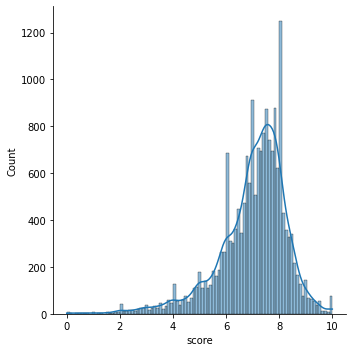

In [4]:
reviews = dfs['reviews']
sns.displot(reviews['score'], kde=True);

Our target is definitely not normally distributed. Notice the outliers at 6, 7, and 8. Out of curiosity, what albums have gotten a 0, and what albums have gotten a 10?

In [5]:
albums_10 = reviews[reviews['score'] ==10]['title'].tolist()
print(albums_10)
print('\n')
albums_0 = reviews[reviews['score'] == 0]['title'].tolist()
del albums_0[2]
print(albums_0)

['metal box', 'blood on the tracks', 'another green world', 'songs in the key of life', 'in concert', "tonight's the night", 'hounds of love', 'sign "o" the times', '1999', 'purple rain', 'dirty mind', 'off the wall', '"heroes"', 'low', 'a love supreme: the complete masters', "people's instinctive travels and the paths of rhythm", 'astral weeks', 'loaded: re-loaded 45th anniversary edition', 'sticky fingers', 'it takes a nation of millions to hold us back', 'the velvet underground  45th anniversary super deluxe edition', 'spiderland', 'the infamous', 'white light/white heat', 'in utero: 20th anniversary edition', 'rumours', 'illmatic', 'donuts (45 box set)', 'voodoo', 'the disintegration loops', 'liquid swords: chess box deluxe edition', "isn't anything", 'tago mago [40th anniversary edition]', 'the smile sessions', 'laughing stock', 'nevermind [20th anniversary edition]', 'emergency & i [vinyl reissue]', 'my beautiful dark twisted fantasy', 'disintegration [deluxe edition]', 'exile on

The distribution actually makes a good deal of sense intuitively. Pitchfork is only reviewing albums they choose to review, which are more likely to be good than bad. What's more, severely negative reviews from Pitchfork can crater an indie artist's career, and giving an album a 0 is a serious statement. The albums with 0s tend to be from artists that released critically acclaimed work, then changed their style or "sold out" according to Pitchfork.

Now let's get back to our analysis. We need to join some of the tables together in order to get more variables to work with. All of the tables are connected together with the variable "reviewid", which is handy, but not efficient database-wise.

In [6]:
reviews = dfs['reviews']
reviews = reviews.merge(dfs['content'], on='reviewid', how='left')
reviews = reviews.merge(dfs['genres'],  on='reviewid', how='left')

reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,content,genre
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,"“Trip-hop” eventually became a ’90s punchline,...",electronic
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,"Eight years, five albums, and two EPs in, the ...",metal
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,Minneapolis’ Uranium Club seem to revel in bei...,rock
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,Kleenex began with a crash. It transpired one ...,rock
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,It is impossible to consider a given release b...,electronic


## Featurizing
We now have the data we want all in the same table, but it's currently not in a format we can use to predict anything. For instance, we might like to know whether the genre of the album was released affects the rating given by Pitchfork. Did they give higher ratings to rock, electronic, or metal?

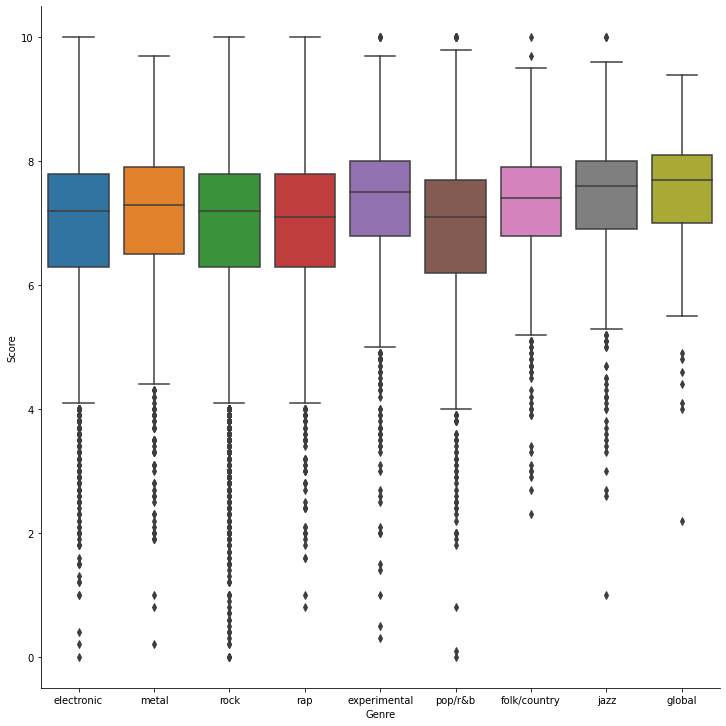

In [7]:
def plot_dists(x, y, x_title, y_title):
    ax = sns.catplot(x=x, y=y, kind='box', data=reviews, height=10);
    ax.set(xlabel=x_title, ylabel=y_title);
plot_dists('genre', 'score', 'Genre', 'Score')

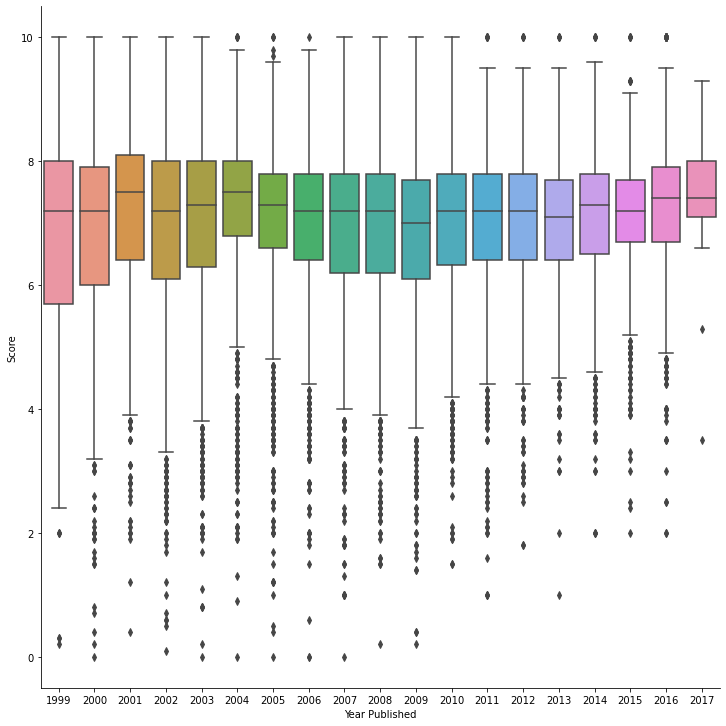

In [8]:
plot_dists('pub_year', 'score', 'Year Published', 'Score')

The means aren't *that* different, but they are different. The distributions also vary in how dispersed they are, as we might expect, since Pitchfork reviews a lot less global music than they do rock.

In [9]:
reviews = pd.get_dummies(reviews, prefix='genre', columns=['genre'])
reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,...,content,genre_electronic,genre_experimental,genre_folk/country,genre_global,genre_jazz,genre_metal,genre_pop/r&b,genre_rap,genre_rock
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,...,"“Trip-hop” eventually became a ’90s punchline,...",1,0,0,0,0,0,0,0,0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,...,"Eight years, five albums, and two EPs in, the ...",0,0,0,0,0,1,0,0,0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,...,Minneapolis’ Uranium Club seem to revel in bei...,0,0,0,0,0,0,0,0,1
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,...,Kleenex began with a crash. It transpired one ...,0,0,0,0,0,0,0,0,1
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,...,It is impossible to consider a given release b...,1,0,0,0,0,0,0,0,0


We now have all our genres in separate variables, coded by a 1 if the review is from that genre and 0 otherwise. We can do the same thing with a few other variables.  Note that I could create a function to do this, it would look like:

In [10]:
def create_dummies(reviews, prefix, column):
    reviews = pd.get_dummies(reviews, prefix=prefix, columns=[column])
    return reviews

prefixes = ['author_type', 'author']
columns  = prefixes
for prefix, column in zip(prefixes, columns):
    reviews = create_dummies(reviews, prefix, column)

In [11]:
reviews.head()

,reviewid,title,artist,url,score,best_new_music,pub_date,pub_weekday,pub_day,pub_month,...,author_william bowers,author_william morris,author_winston cook-wilson,author_yancey strickler,author_zach baron,author_zach hammerman,author_zach hooker,author_zach kelly,author_zach vowell,author_zoe camp
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,2017-01-08,6,8,1,...,0,0,0,0,0,0,0,0,0,0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,2017-01-07,5,7,1,...,0,0,0,0,0,0,0,0,0,1
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,2017-01-07,5,7,1,...,0,0,0,0,0,0,0,0,0,0
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,2017-01-06,4,6,1,...,0,0,0,0,0,0,0,0,0,0
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,2017-01-06,4,6,1,...,0,0,0,0,0,0,0,0,0,0


### Featurizing Text

We now have some good features to use. Let's now try to make the text of the review into some features we can use to predict the score.

The first, and simplest, tool we can use is the length of the review in characters, words, and sentences. 

In [12]:
reviews['review_len_in_chars'] = [len(review) for review in reviews['content']]
reviews['review_len_in_words'] = [len(review.split()) for review in reviews['content']]
# reviews['review_len_in_words'] = [len(list(nlp(review).sents)) for review in reviews['content']]
# ^ takes too long

In [13]:
good_token = nlp('good')
good_token.has_vector

True

I'm going to calculate the average "good"-ness of each review by taking the sum of the similarities of each word vector and the word vector for "good", then dividing by the number of words in the review. This is a bit silly, but it should be an ok heuristic.

In [14]:
def calculate_goodness(good_token, review_contents):
    goodness_list = []
    for content in review_contents:
        content = nlp(content)
        num_words = len(content)
        if num_words == 0:
            goodness_list.append(0)
            continue
        total_goodness = functools.reduce(lambda curr_sum, curr_token: curr_sum + curr_token.similarity(good_token), content, 0)
        goodness_list.append(total_goodness/num_words)
    return goodness_list

reviews['goodness'] = calculate_goodness(good_token ,reviews['content'])

<ipython-input-14-4f0f5f763048>:9: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  total_goodness = functools.reduce(lambda curr_sum, curr_token: curr_sum + curr_token.similarity(good_token), content, 0)


In [15]:
reviews = reviews[reviews['goodness'] != 0]

I don't want some of the data that's in reviews-- for instance, I don't want the reviewid. 

In [16]:
reviews = reviews.drop(['reviewid'], 1)

Finally, I'm going to get rid of the non-numeric columns because we can't use them to predict. 

In [17]:
reviews = reviews.select_dtypes(include='number')

## Prediction

This lab is emblematic of most machine learning projects. The vast majority of the time is spent on data cleaning and preparing data for the prediction algorithm, and very little is spent on the prediction itself. We'll use two algorithms here.

### Training and Testing

In [18]:
review_scores = reviews['score']

In [19]:
reviews = reviews.drop('score', 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(reviews, review_scores, test_size=0.1)

### Linear Regression (OLS)

In [21]:
reg = LinearRegression().fit(X_train, y_train)
#R^2
reg.score(X_train, y_train)

0.23903478726360416

In [22]:
y_test_pred_ols = reg.predict(X_test)
mean_squared_error(y_test, y_test_pred_ols)

46307446731.39946

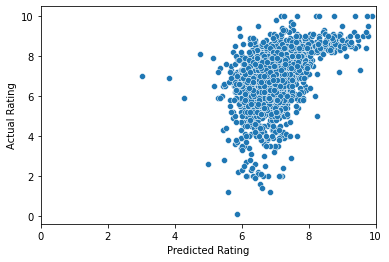

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(x=y_test_pred_ols, y=y_test)
ax.set_xlim(0,10)
ax.set(xlabel='Predicted Rating', ylabel='Actual Rating');
plt.show()

Our predictive accuracy isn't very high here, but that's to be expected. OLS is very easy to interpret but doesn't have the best predictive power. 

Interpreting the plot, if we were perfectly accurate then our points would lie along the 45 degree angle of actual rating = predicted rating. Clearly our predictions are skewing higher than they should. This could be because we have fewer examples of low scores-- we have a biased sample because there aren't many low scoring reviews in the data.

### Random Forests

In [24]:
rf = RandomForestRegressor(n_estimators=500).fit(X_train, y_train)

In [25]:
rf.score(X_train, y_train)
#R^2

0.9143095127047651

In [26]:
y_test_pred_rf = rf.predict(X_test)
mean_squared_error(y_test, y_test_pred_rf)

0.9456452152422902

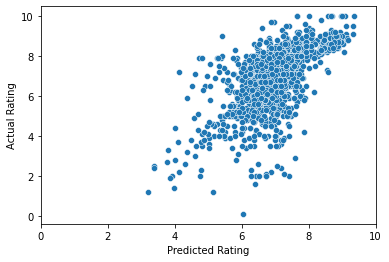

In [27]:
fig, ax = plt.subplots()
sns.scatterplot(x=y_test_pred_rf, y=y_test)
ax.set_xlim(0,10)
ax.set(xlabel='Predicted Rating', ylabel='Actual Rating');
plt.show()

## Results
Our Random Forests model is a bit better than our OLS model as expected, but not *that* much better. Our distribution is closer to the X=Y diagonal but there's definitely still some improvements we could make. The implicit tradeoff we're making here is that as you know, I can look at the coefficients of each of the variables and evaluate the effect they have on the overall prediction. I can't really do that with Random Forests. There are ways to look at the importance of certain variables though. The larger point is that there is a tradeoff in machine learning between predictive power and interpretability. It might not be there forever, as neural networks and ensemble methods become more interpretable by the day, but as of today it stands. 

463               goodness
461    review_len_in_chars
462    review_len_in_words
0           best_new_music
2                  pub_day
4                 pub_year
3                pub_month
1              pub_weekday
185       author_ian cohen
13              genre_rock
Name: Vars, dtype: object


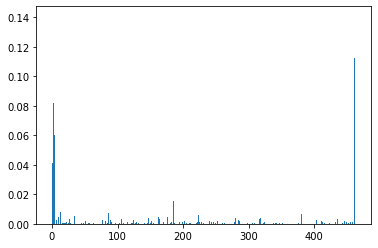

In [28]:
importance = rf.feature_importances_
var_imp_df = pd.DataFrame(data={'Vars': reviews.columns.tolist(), 'Importance': importance})
var_imp_df = var_imp_df.sort_values(by='Importance', ascending=False)
print(var_imp_df['Vars'][:10])
plt.bar([x for x in range(len(importance))], importance)
plt.show()